In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
file_to_load = "./DATA/2019-Oct.csv"

chunksize = 50_000
fraction = 0.01
seed = 42

In [3]:
chunks = pd.read_csv(file_to_load, chunksize=chunksize, parse_dates=['event_time'])

In [4]:
def getRandomDataset(chunks, frac, seed):
    return pd.concat(chunk.sample(frac=frac, random_state=seed) for chunk in chunks)

In [5]:
df = getRandomDataset(chunks, fraction, seed)

# Exploration

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
33553,2019-10-01 03:12:25+00:00,view,13200276,2053013557192163841,furniture.bedroom.bed,brw,130.76,529306458,cab02446-c43b-4d57-ab7c-e0c850de22a6
9427,2019-10-01 02:36:19+00:00,view,23000277,2164367422893589471,NaN,mitasu,20.59,516640053,ce9d2b9e-bbf4-42bb-9034-f7b6ad36013e
199,2019-10-01 00:02:46+00:00,view,3200321,2053013555321504139,appliances.kitchen.meat_grinder,redmond,91.38,515744951,d35a2b1e-a781-45c4-a4f1-7e851d2a4c16
12447,2019-10-01 02:41:29+00:00,view,9000121,2053013566067311601,NaN,janome,216.53,517859956,73641920-7de0-4a1b-89dd-75fb7a13d084
39489,2019-10-01 03:19:56+00:00,view,21403078,2053013561579406073,electronics.clocks,casio,39.05,512904025,d5e9ab30-2685-42cb-b4db-5a2d5ad4fd84


In [7]:
df.describe()

,product_id,category_id,price,user_id
count,4.244880e+05,4.244880e+05,424488.000000,4.244880e+05
mean,1.055876e+07,2.057400e+18,289.422948,5.335261e+08
std,1.188062e+07,1.842630e+16,357.543821,1.852428e+07
min,1.000978e+06,2.053014e+18,0.000000,2.050532e+08
25%,1.005158e+06,2.053014e+18,65.640000,5.159180e+08
50%,5.000568e+06,2.053014e+18,161.910000,5.296808e+08
75%,1.600055e+07,2.053014e+18,358.440000,5.515535e+08
max,6.050000e+07,2.175420e+18,2574.070000,5.662785e+08


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424488 entries, 33553 to 42441190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     424488 non-null  datetime64[ns, UTC]
 1   event_type     424488 non-null  object             
 2   product_id     424488 non-null  int64              
 3   category_id    424488 non-null  int64              
 4   category_code  289301 non-null  object             
 5   brand          363211 non-null  object             
 6   price          424488 non-null  float64            
 7   user_id        424488 non-null  int64              
 8   user_session   424488 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 32.4+ MB


In [9]:
def createNaAndUniqueMatrix(df):
    rows = ["Valeurs nulles", "Valeurs uniques"]

    data = {}

    for column in df.columns:    
        na = df[column].isna()
        unique = len(df[column][~na].unique())

        data[column] = [f'{len(df[na])} ({(len(df[na])/len(df))*100:.2f}%)', unique]

    return pd.DataFrame(data, index=rows)

In [10]:
createNaAndUniqueMatrix(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
Valeurs nulles,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),135187 (31.85%),61277 (14.44%),0 (0.00%),0 (0.00%),0 (0.00%)
Valeurs uniques,383432,3,59203,597,126,2428,28792,320848,399005


Analysons les 3 valeurs uniques d'event_type

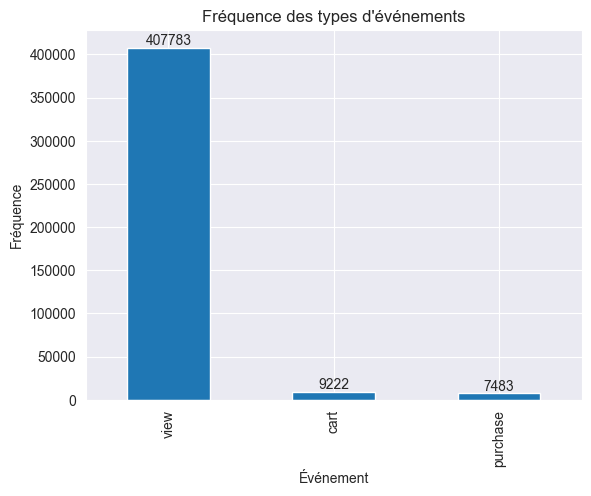

In [11]:
frequences = df["event_type"][df["event_type"].notna()].value_counts()

ax = frequences.plot(kind="bar")

for i,v in enumerate(frequences):
    ax.text(i, v + 0.1, str(v), ha="center", va="bottom")

plt.title("Fréquence des types d'événements")
plt.xlabel("Événement")
plt.ylabel("Fréquence")
plt.show()

On recense donc 407 757 vues, 9237 mises dans un panier et 7494 achats

Quels sont les taux de conversion entre les types d'événements ?

In [12]:
viewToCart = frequences["cart"] / frequences["view"] * 100
cartToPurchase = frequences["purchase"] / frequences["cart"] * 100
viewToPurchase = frequences["purchase"] / frequences["view"] * 100

print(f"Taux de conversion vue => panier : {viewToCart:.2f} %")
print(f"Taux de conversion panier => achat : {cartToPurchase:.2f} %")
print(f"Taux de conversion vue => achat : {viewToPurchase:.2f} %")

Taux de conversion vue => panier : 2.26 %
Taux de conversion panier => achat : 81.14 %
Taux de conversion vue => achat : 1.84 %


Combien d'utilisateurs différents ont fait un achat ?

In [38]:
usersPurchased = len(df["user_id"][df["event_type"] == "purchase"].unique())

itemsPurchasedPerUser = frequences["purchase"] / usersPurchased

maxUserBuy = df[df["event_type"] == "purchase"].groupby("user_id").size().max()
maxSessionBuy = df[df["event_type"] == "purchase"].groupby("user_session").size().max()

print(f"Un total de {usersPurchased} utilisateurs différents ont effectué des achats sur le site")
print(f"Un utilisateur qui achète sur le site achète en moyenne {itemsPurchasedPerUser:.2f} articles")
print(f"L'utilisateur qui a le plus acheté a acheté {maxUserBuy} articles sur le mois")
print(f"La session utilisateur qui a le plus acheté a acheté {maxSessionBuy} articles en une session")

KeyError: 'event_type'

Comment évoluent les achats sur le mois ?

In [14]:
datesDayToDay = pd.to_datetime(df["event_time"]).dt.date
purchasesDayToDay = df[df["event_type"] == "purchase"].groupby(datesDayToDay)["event_type"].count()
uniqueDates = datesDayToDay.unique()

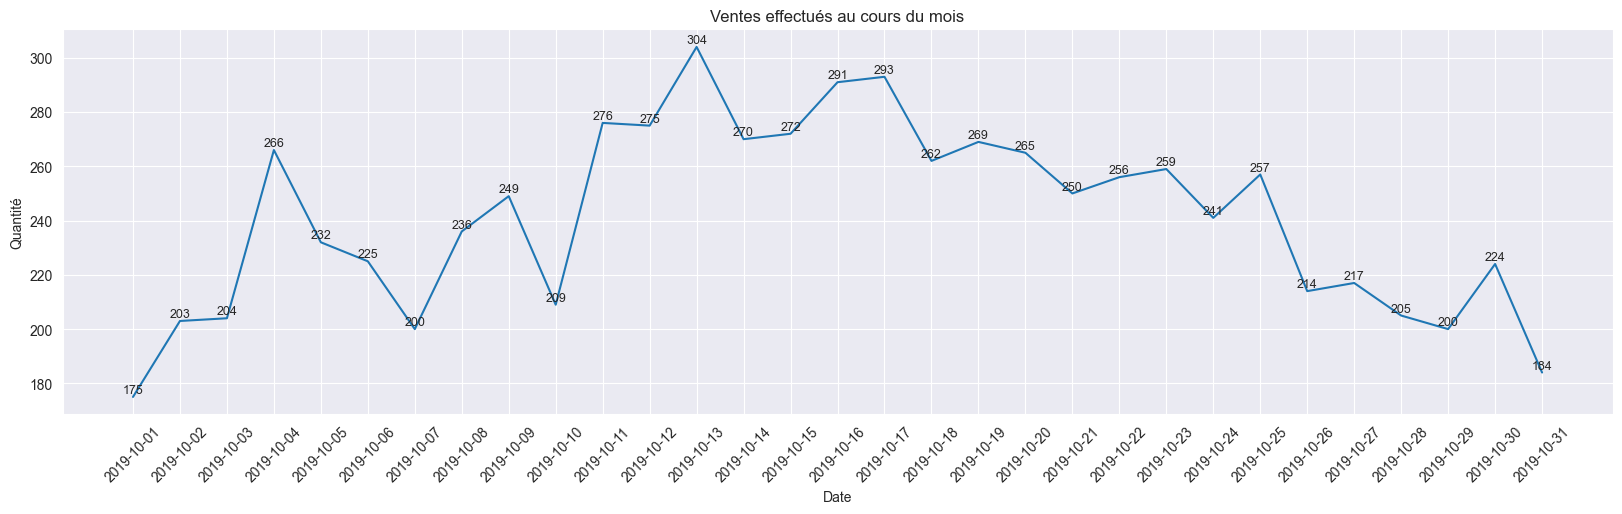

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(uniqueDates, purchasesDayToDay)

for x,y in zip(uniqueDates, purchasesDayToDay):
    plt.text(x, y + 0.3, y, ha="center", va="bottom", fontsize=9)

plt.title("Ventes effectués au cours du mois")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.grid(True)
plt.xticks(uniqueDates, rotation=45)

plt.show()

Quel est le chiffre d'affaire quotidien ?

In [16]:
datesDayToDay = pd.to_datetime(df["event_time"]).dt.date
gainsDayToDay = df[df["event_type"] == "purchase"].groupby(datesDayToDay)["price"].sum()
uniqueDates = datesDayToDay.unique()

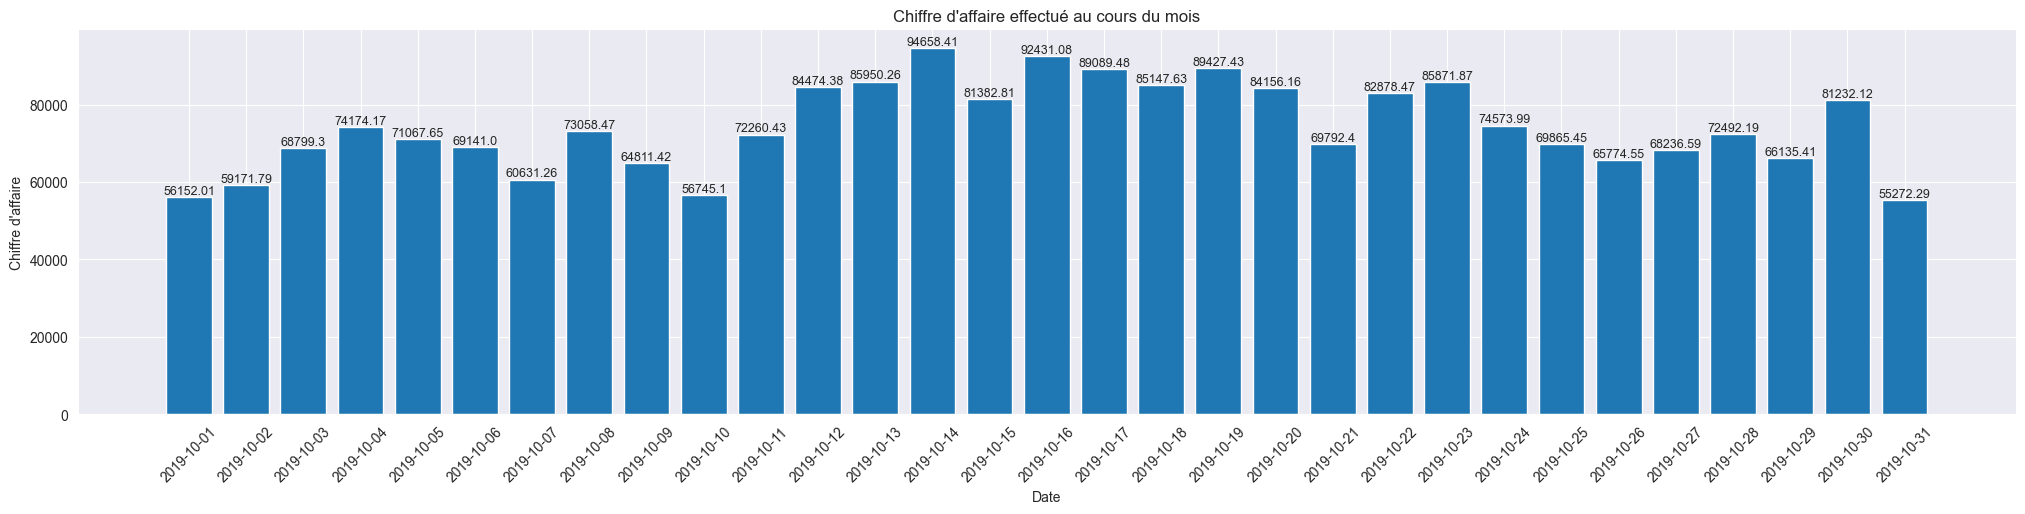

In [17]:
plt.figure(figsize=(25, 5))
plt.bar(uniqueDates, gainsDayToDay)

for x,y in zip(uniqueDates, gainsDayToDay):
    plt.text(x, y + 0.3, y, ha="center", va="bottom", fontsize=9)

plt.title("Chiffre d'affaire effectué au cours du mois")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.grid(True)
plt.xticks(uniqueDates, rotation=45)

plt.show()

# Transformation

In [18]:
import numpy as np

In [19]:
df = pd.get_dummies(df, columns=["event_type"])

In [20]:
encoder = OneHotEncoder(sparse_output=False)

In [22]:
# Encoder chaque cycle en cos/sin
df['day_of_year'] = df['event_time'].dt.dayofyear
df['day_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['day_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)

df['day_of_week'] = df['event_time'].dt.weekday  # 0=lundi
df['day_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['day_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)

df['hour'] = df['event_time'].dt.hour
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)

df['minute'] = df['event_time'].dt.hour * 60 + df['event_time'].dt.minute
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 1440)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 1440)

df.drop(['event_time', 'day_of_year', 'day_of_week', 'hour', 'minute'], axis=1, inplace=True)

In [23]:
df.head()

,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view,day_year_cos,day_year_sin,day_week_cos,day_week_sin,hour_cos,hour_sin,minute_cos,minute_sin
33553,13200276,0.0,furniture.bedroom.bed,brw,130.76,529306458,cab02446-c43b-4d57-ab7c-e0c850de22a6,False,False,True,0.004304,-0.999991,0.62349,0.781831,0.707107,0.707107,0.669131,0.743145
9427,23000277,0.0,NaN,mitasu,20.59,516640053,ce9d2b9e-bbf4-42bb-9034-f7b6ad36013e,False,False,True,0.004304,-0.999991,0.62349,0.781831,0.866025,0.500000,0.777146,0.629320
199,3200321,0.0,appliances.kitchen.meat_grinder,redmond,91.38,515744951,d35a2b1e-a781-45c4-a4f1-7e851d2a4c16,False,False,True,0.004304,-0.999991,0.62349,0.781831,1.000000,0.000000,0.999962,0.008727
12447,9000121,0.0,NaN,janome,216.53,517859956,73641920-7de0-4a1b-89dd-75fb7a13d084,False,False,True,0.004304,-0.999991,0.62349,0.781831,0.866025,0.500000,0.763232,0.646124
39489,21403078,0.0,electronics.clocks,casio,39.05,512904025,d5e9ab30-2685-42cb-b4db-5a2d5ad4fd84,False,False,True,0.004304,-0.999991,0.62349,0.781831,0.707107,0.707107,0.646124,0.763232


Cherchons maintenant les corrélations entre les différentes features

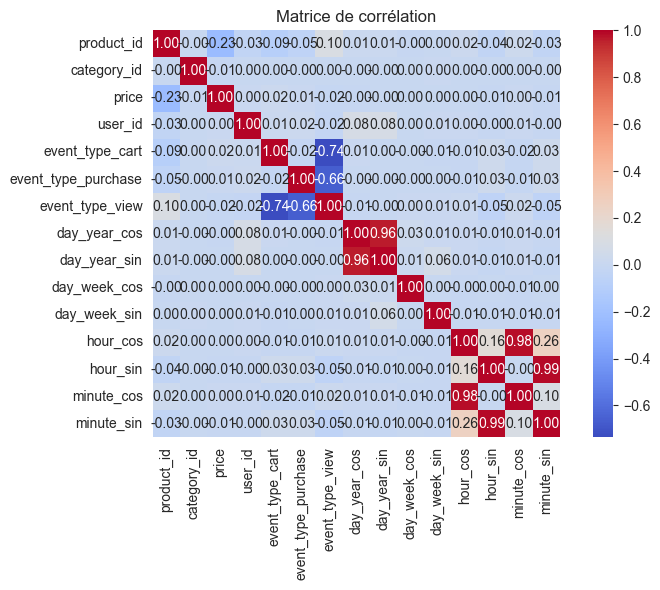

In [24]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

# Remarques

Regrouper les clients par intéractions panier/nombre de connexions
Achat par heure de la journée
PySpark
Analyses Bivariées
Retravailler les données
Qualitatif -> Quantitatif
Test de Anova et Chi^2

In [25]:
df_final = df.drop(['product_id', 'category_id', 'category_code', 'brand', 'user_session'], axis=1)

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

In [39]:
df_scaled.head()

array([[-0.44375857, -0.22778846, -0.14902165, ...,  1.70304121,
         0.97872694, -0.018653  ],
       [-0.751889  , -0.91156241, -0.14902165, ...,  1.89198953,
         0.82933346, -0.018653  ],
       [-0.55389905, -0.95988294, -0.14902165, ...,  2.28175542,
         0.01480996, -0.018653  ],
       ...,
       [ 1.26870487,  0.10589115, -0.14902165, ...,  2.04746392,
        -0.65288875, -0.018653  ],
       [-0.30769117,  1.76657776, -0.14902165, ...,  1.69735793,
        -0.9758367 , -0.018653  ],
       [-0.73099643,  1.67892917, -0.14902165, ...,  2.21614599,
        -0.35290652, -0.018653  ]], shape=(424488, 14))

# Modèle

In [28]:
from sklearn.cluster import DBSCAN

## Recherche des hyperparamètres

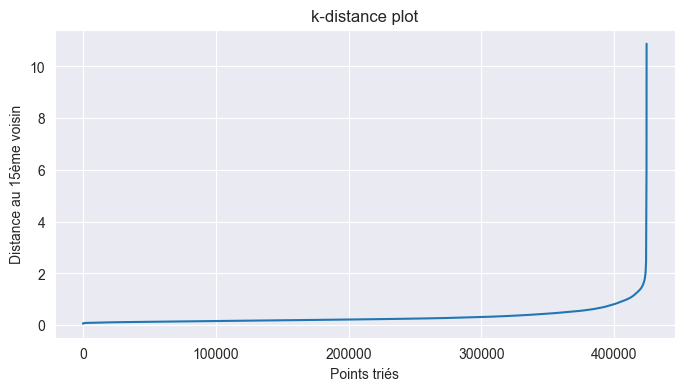

In [52]:
from sklearn.neighbors import NearestNeighbors

min_samples = df_scaled.shape[1] + 1

# Calcul des distances au k-ième plus proche voisin
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# On prend la distance au dernier voisin (le k-ième)
distances = np.sort(distances[:, -1])

# Tracer la courbe
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Points triés")
plt.ylabel(f"Distance au {min_samples}ème voisin")
plt.title("k-distance plot")
plt.show()

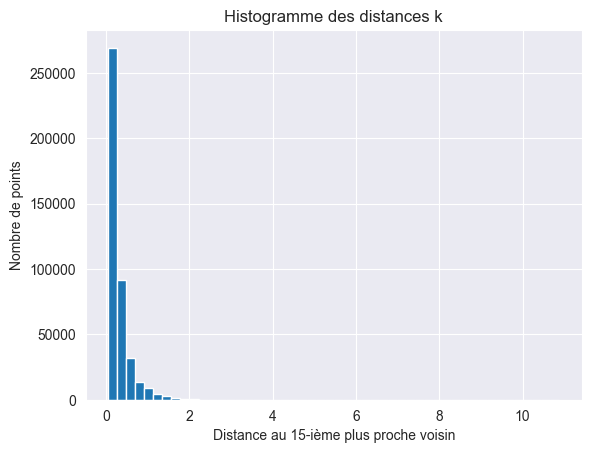

In [53]:
plt.hist(distances, bins=50)
plt.xlabel(f"Distance au {min_samples}-ième plus proche voisin")
plt.ylabel("Nombre de points")
plt.title("Histogramme des distances k")
plt.show()

In [54]:
print(f"Min distance: {distances.min()}")
print(f"Max distance: {distances.max()}")
print(f"Moyenne distance: {distances.mean()}")
print(f"25% quantile: {np.percentile(distances, 25)}")
print(f"50% quantile: {np.percentile(distances, 50)}")
print(f"75% quantile: {np.percentile(distances, 75)}")

Min distance: 0.057626426275593855
Max distance: 10.879798881107487
Moyenne distance: 0.3184900270200659
25% quantile: 0.16503293030105734
50% quantile: 0.22772899605513391
75% quantile: 0.3527659986814327


In [ ]:
eps_values = [1, 1.2, 1.4, 1.6, 1.7, 1.8, 1.9, 2]
for eps in eps_values:
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = list(labels).count(-1) / len(labels)
    print(f"eps={eps:.2f} -> clusters: {n_clusters}, bruit: {noise_ratio*100:.2f}%")

## Modèle final

In [30]:
clustering = DBSCAN(eps=3, min_samples=min_samples).fit(df_scaled)

In [31]:
labels = clustering.labels_
df_scaled['cluster'] = labels

# Nombre de clusters trouvés (hors bruit)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(f"Nombre de clusters trouvés : {n_clusters}")

Nombre de clusters trouvés : 34


In [32]:
print(f"Bruit : {(df_scaled['cluster'] == -1).sum()}, soit {((df_scaled['cluster'] == -1).sum()) / df_scaled.shape[0] * 100}% des données")

Bruit : 424290, soit 99.95335557188896% des données


In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# On retire le bruit
mask = df_scaled['cluster'] != -1
X_no_noise = df_scaled.drop(columns=['cluster'])[mask]
labels_no_noise = df_scaled['cluster'][mask]

if len(set(labels_no_noise)) > 1:
    score = silhouette_score(X_no_noise, labels_no_noise)
    print(f"Silhouette Score : {score:.3f}")
    ch_score = calinski_harabasz_score(X_no_noise[mask], labels[mask])
    print(f"Calinski-Harabasz : {ch_score:.3f}")
    db_score = davies_bouldin_score(X_no_noise[mask], labels[mask])
    print(f"Davies-Bouldin : {db_score:.3f}")
else:
    print("Pas assez de clusters pour calculer le score.")

Silhouette Score : 0.965
Calinski-Harabasz : 432491987201954.000
Davies-Bouldin : 0.064


C:\Users\trist\AppData\Local\Temp\ipykernel_1240\2468312940.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ch_score = calinski_harabasz_score(X_no_noise[mask], labels[mask])
C:\Users\trist\AppData\Local\Temp\ipykernel_1240\2468312940.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  db_score = davies_bouldin_score(X_no_noise[mask], labels[mask])


## Visualisation des clusters

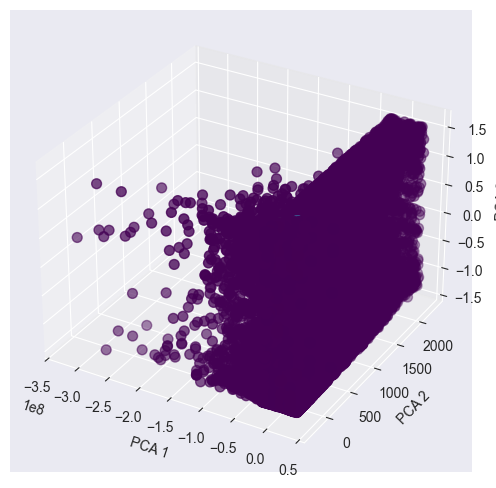

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
reduced = pca.fit_transform(df_final.drop(columns=['cluster']))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2],
           c=df_final['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()